# **Install dependencies and preparing**

In [ ]:
#import the numpy and pandas libraries for data manipulation and analysis.
import numpy as np
import pandas as pd
#import the matplotlib library for creating plots and visualizations.
import matplotlib.pyplot as plt

#is to allows the visualizations to be rendered directly in the notebook.
%matplotlib inline

# DataViz
#imports the seaborn library for creating more complex visualizations.
import seaborn as sns


#imports the pingouin and dfply library for statistical analysis and data manipulation.
import pingouin as pg
from dfply import *

# Modeling
#import the necessary modules from the scikit-learn library for machine learning (Knn,SVM).
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


#imports modules for working with Google sheets(authentication process).
from google.colab import auth
auth.authenticate_user()

# is a step to authorize the connection to the google sheet.
import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)





In [ ]:
##############################################
# This is working with Google sheets by      #
# opening an existing Google sheet called    #
# "ML220930" .Then, it's creating dataframe  #
# for each worksheet in the google sheet.    #
##############################################

#upload the dataset to you drive and then, opens the google sheet with the title "BlockchainDataset".
worksheet = gc.open('BlockchainDataset')



# to creates a variable for each worksheet in the google sheet, so that the data from each worksheet can be accessed and manipulated.
config = worksheet.worksheet("config")
Results = worksheet.worksheet("Results")
block = worksheet.worksheet("block")
Transactions = worksheet.worksheet("Transactions")
TransactionLatency = worksheet.worksheet("TransactionLatency")
TransactionPool = worksheet.worksheet("TransactionPool")
Test = worksheet.worksheet("Test")
Pred = worksheet.worksheet("Prediction")

# to creates a pandas dataframe for each worksheet, so that the data can be easily manipulated using pandas functions.
cnf = pd.DataFrame(config.get_all_records())
rst = pd.DataFrame(Results.get_all_records())
tst = pd.DataFrame(Test.get_all_records())
prd = pd.DataFrame(Pred.get_all_records())

#is used to drop the 'Simulator No. Run' column from the rst and cnf dataframe.
rst.drop('Simulator No. Run', inplace=True, axis=1)
cnf.drop('Simulator No. Run', inplace=True, axis=1)

# **Preprocessing**

**Configuration parameters**

This section will preprocess the configuration parameters found in the dataset.

In [ ]:
#Creating a new variable named "BC" and assigns the value of the "cnf" variable to it.
BC = cnf


In [ ]:
#To returns the number of rows and columns in the dataframe "BC".
BC.shape

(184, 9)

**Results (Metrics)**

This section will preprocess the results based on configuration parameters that found in the dataset.

In [ ]:
#To returns the number of rows and columns in the dataframe "rst".
rst.shape

(184, 13)

In [ ]:
# to provide a summary of statistics for the 13th column of the dataframe "rst".
rst.iloc[:,12].describe()

count     184.000000
mean      508.306157
std       268.197662
min        11.184104
25%       291.559383
50%       527.806390
75%       711.309347
max      1248.655264
Name: Transaction Throughput (Tx/secs), dtype: float64

# **Predication**

In [ ]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import time
import json

In [ ]:
# Function to calculate performance metrics
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    if r2 < 0:
        r2 = 0
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, rmse

In [ ]:
# Objective function for Optuna
def objective(trial, model, X_train, X_test, y_train, y_test):
    if isinstance(model, SVR):
        params = {
            'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
            'C': trial.suggest_float('C', 0.1, 10.0),
            'epsilon': trial.suggest_float('epsilon', 0.01, 1.0)
        }
    elif isinstance(model, RandomForestRegressor):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 10, 30)
        }
    elif isinstance(model, KNeighborsRegressor):
        params = {
            'n_neighbors': trial.suggest_int('n_neighbors', 3, 20),
            'weights': trial.suggest_categorical('weights', ['uniform', 'distance'])
        }
    elif isinstance(model, XGBRegressor):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2)
        }
    elif isinstance(model, CatBoostRegressor):
        params = {
            'iterations': trial.suggest_int('iterations', 50, 200),
            'depth': trial.suggest_int('depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2)
        }
    elif isinstance(model, LGBMRegressor):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'num_leaves': trial.suggest_int('num_leaves', 31, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2)
        }

    model.set_params(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    return score

In [ ]:
# Function to make predictions
def make_predictions(model, model_name, results, save_dir, n_repeats=3, search_type=None, param_distributions=None):
    for i in range(rst.shape[1]):
        X = cnf
        y = rst.iloc[:, i]

        if y.nunique() > 1:  # Check if there are at least two instances of each class
            for repeat in range(n_repeats):
                  random_state = np.random.randint(1000)
                  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

                  if search_type == 'optuna':
                      study = optuna.create_study(direction='maximize')
                      study.optimize(lambda trial: objective(trial, model, X_train, X_test, y_train, y_test), n_trials=10)
                      best_params = study.best_params
                      model.set_params(**best_params)
                  elif search_type == 'randomized':
                      search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=5, scoring='r2', n_jobs=2, random_state=42)
                      search.fit(X_train, y_train)
                      model = search.best_estimator_
                      best_params = search.best_params_
                  elif search_type == 'grid':
                      search = GridSearchCV(model, param_distributions, cv=5, scoring='r2', n_jobs=2)
                      search.fit(X_train, y_train)
                      model = search.best_estimator_
                      best_params = search.best_params_
                  else:
                      model.fit(X_train, y_train)
                      best_params = model.get_params()

                  # training time
                  start_time = time.time()
                  model.fit(X_train, y_train)
                  train_time = time.time() - start_time

                  # prediction time
                  start_time = time.time()
                  y_pred = model.predict(X_test)
                  pred_time = time.time() - start_time

                  # Calculate metrics
                  r2, rmse = calculate_metrics(y_test, y_pred)

                  # Calculate model score
                  score = model.score(X_test, y_test)

                  # Store results
                  results.append({
                      'model': model_name,
                      'column': i,
                      'score': score,
                      'r2_score': r2,
                      'rmse': rmse,
                      'repeat': repeat,
                      'train_time': train_time,
                      'pred_time': pred_time,
                      'params': json.dumps(best_params)
                  })

                  preds = model.predict(tst)
                  if i < 5:
                      print(f"{model_name} - Column {i} - Repeat {repeat} : {np.round(preds)}")
                      prd.iloc[repeat, i] = np.round(preds)
                  else:
                      print(f"{model_name} - Column {i} - Repeat {repeat} : {preds}")
                      prd.iloc[repeat, i] = preds

                  # Save the trained model
                  joblib.dump(model, os.path.join(save_dir, f'best_model_{model_name}_col_{i}_repeat_{repeat}.pkl'))

        else:
            print(f"Skipping column {i} -> unique class.")

In [ ]:
# Function to run predictions in parallel
def run_model_predictions(model, model_name, search_type=None, param_distributions=None):
    make_predictions(model, model_name, results, save_dir, n_repeats, search_type=search_type, param_distributions=param_distributions)

In [ ]:
# Read the saved data
def load_results(results_path, models_dir):
    results_df = pd.read_csv(results_path)
    best_models = {}
    for model_file in os.listdir(models_dir):
        if model_file.endswith('.pkl'):
            model_name = model_file.split('best_model_')[-1].split('.pkl')[0]
            best_models[model_name] = joblib.load(os.path.join(models_dir, model_file))
    return results_df, best_models

In [ ]:
# Read the saved data
def describe_results(results_df):
    print(results_df.describe())

In [ ]:
# Plot functions
def plot_metrics(results_df):
    metrics = ['score', 'r2_score', 'rmse']

    for metric in metrics:
        plt.figure(figsize=(15, 8))
        sns.boxplot(x='model', y=metric, data=results_df)
        plt.title(f'{metric.upper()} Comparison', fontsize=14)
        plt.xlabel('Model', fontsize=12)
        plt.ylabel(metric.upper(), fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()

def plot_mean_metrics(results_df):
    # Removing the 'params' column before calculating the mean
    mean_results = results_df.drop(columns=['params']).groupby(['model', 'repeat']).mean().reset_index()
    metrics = ['score', 'r2_score', 'rmse']

    for metric in metrics:
        plt.figure(figsize=(15, 8))
        sns.boxplot(x='model', y=metric, data=mean_results)
        plt.title(f'Mean {metric.capitalize()} Comparison Across Columns', fontsize=14)
        plt.xlabel('Model', fontsize=12)
        plt.ylabel(f'Mean {metric.capitalize()}', fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()

def remove_outliers(df, metric):
    Q1 = df[metric].quantile(0.25)
    Q3 = df[metric].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    filtered_df = df[(df[metric] >= lower_bound)]
    return filtered_df

#  results without outliers
def plot_metrics_filtered(results_df):
    metrics = ['score', 'r2_score', 'rmse']
    mean_results = results_df.drop(columns=['params']).groupby(['model', 'repeat']).mean().reset_index()
    for metric in metrics:
        filtered_df = remove_outliers(mean_results, metric)
        plt.figure(figsize=(15, 8))
        sns.boxplot(x='model', y=metric, hue='model', data=filtered_df, legend=False)
        plt.title(f'{metric.capitalize()} Comparison (Outliers Removed)', fontsize=14)
        plt.xlabel('Model', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()

def plot_mean_metrics_filtered_after(results_df):
    metrics = ['score', 'r2_score', 'rmse']
    mean_results = results_df.drop(columns=['params']).groupby(['model', 'repeat']).mean().reset_index()
    for metric in metrics:
        filtered_df = remove_outliers(mean_results, metric)
        plt.figure(figsize=(15, 8))
        sns.boxplot(x='model', y=metric, hue='model', data=filtered_df, legend=False)
        plt.title(f'{metric.capitalize()} Comparison (Outliers Removed)', fontsize=14)
        plt.xlabel('Model', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()

def plot_mean_metrics_filtered_before(results_df):
    metrics = ['score', 'r2_score', 'rmse']
    for metric in metrics:
        filtered_df = remove_outliers(results_df.drop(columns=['params']), metric)
        filtered_df = filtered_df.groupby(['model', 'repeat']).mean().reset_index()
        plt.figure(figsize=(15, 8))
        sns.boxplot(x='model', y=metric, hue='model', data=filtered_df, legend=False)
        plt.title(f'{metric.capitalize()} Comparison (Outliers Removed)', fontsize=14)
        plt.xlabel('Model', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.show()

In [ ]:
# Visualizing Results
plt.figure(figsize=(20, 25))

metrics = ['score', 'r2_score', 'rmse']

for metric in metrics:
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='model', y=metric, data=results_df)
    plt.title(f'{metric.upper()} Comparison', fontsize=14
    plt.title(f'{metric.upper()} Comparison', fontsize=14)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel(metric.upper(), fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

results_path = os.path.join(save_dir, 'results.csv')
results_df, best_models = load_results(results_path, save_dir)
describe_results(results_df)
plot_metrics(results_df)
plot_metrics_filtered(results_df)
plot_mean_metrics(results_df)
plot_mean_metrics_filtered_after(results_df)
plot_mean_metrics_filtered_before(results_df)

save_dir_path = os.path.join('/content', save_dir)

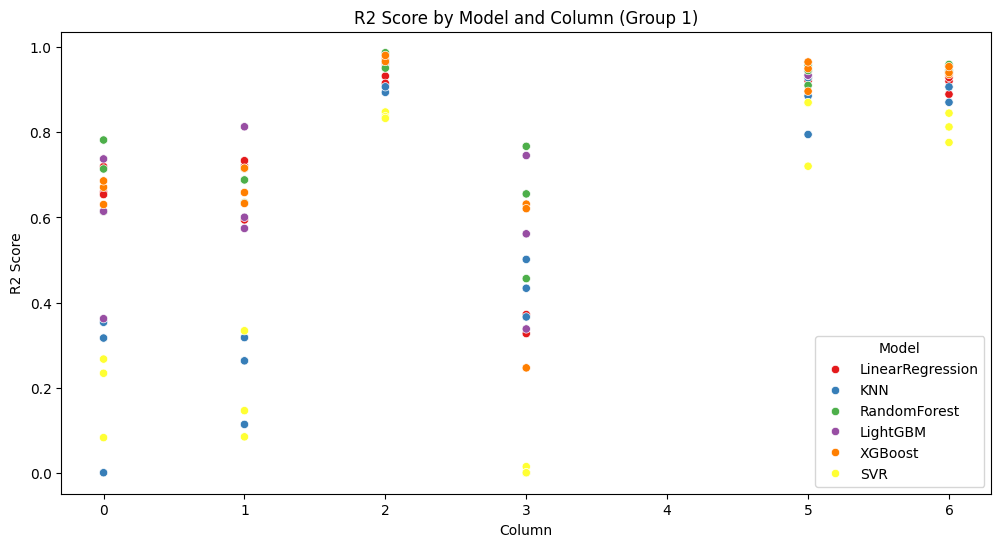

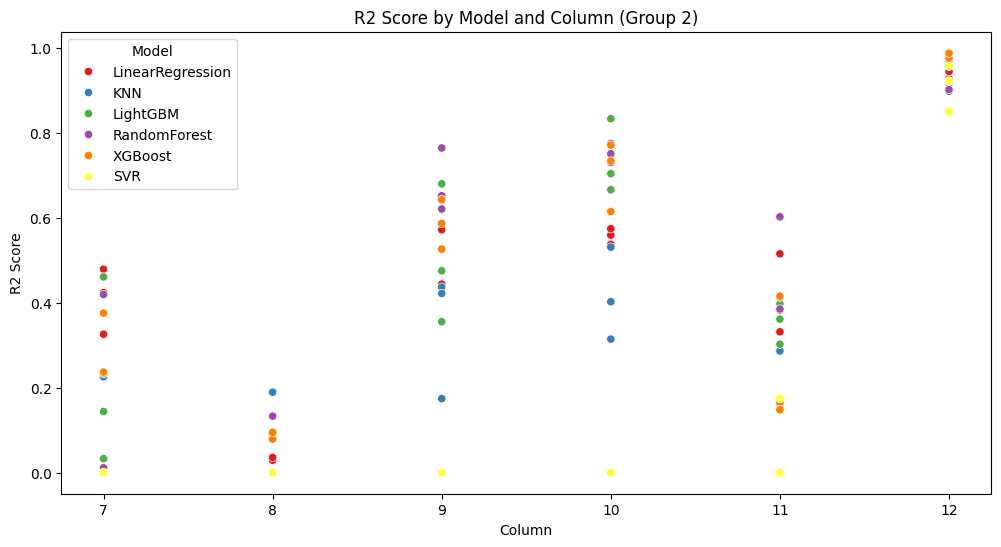

<ipython-input-5-4e210e8bda37>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot_r2 = sns.boxplot(data=df, x='model', y='r2_score', palette='Set2')


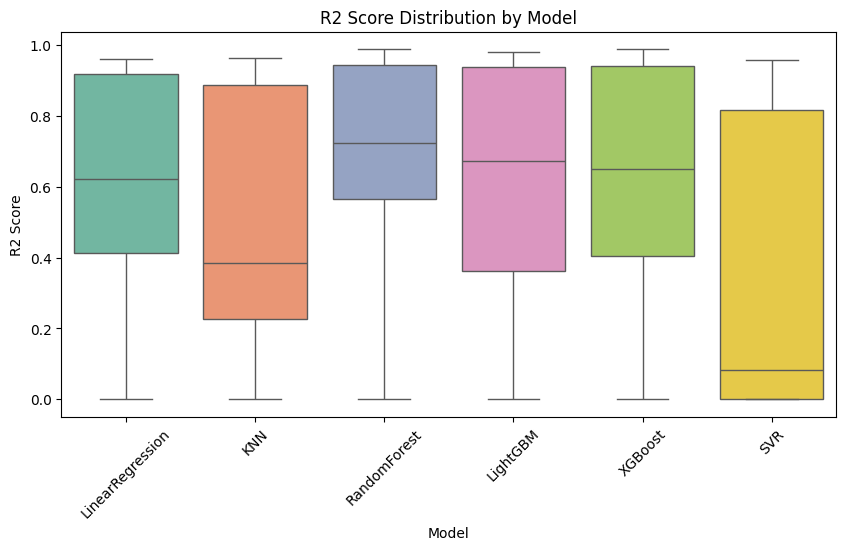

<ipython-input-5-4e210e8bda37>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot_rmse = sns.boxplot(data=df, x='model', y='rmse', palette='Set3')


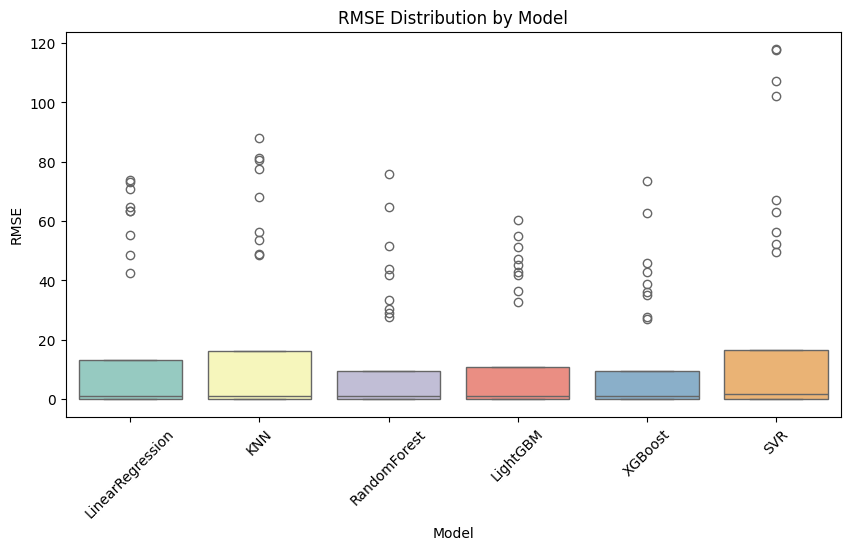

In [ ]:
# Scatter and Boxplots
def load_and_plot_results(file_path):

    df = pd.read_csv(file_path)


    unique_columns = df['column'].unique()

    # Divide the columns into two groups
    columns_groups = [unique_columns[i:i + 6] for i in range(0, len(unique_columns), 6)]

    # Scatter plots for R2 score
    for i, columns_group in enumerate(columns_groups):
        plt.figure(figsize=(12, 6))
        subset_df = df[df['column'].isin(columns_group)]
        scatter = sns.scatterplot(data=subset_df, x='column', y='r2_score', hue='model', palette='Set1')
        scatter.set_title(f'R2 Score by Model and Column (Group {i + 1})')
        scatter.set_xlabel('Column')
        scatter.set_ylabel('R2 Score')
        plt.legend(title='Model')
        plt.show()

    # Boxplot for R2 score
    plt.figure(figsize=(10, 5))
    boxplot_r2 = sns.boxplot(data=df, x='model', y='r2_score', palette='Set2')
    boxplot_r2.set_title('R2 Score Distribution by Model')
    boxplot_r2.set_xlabel('Model')
    boxplot_r2.set_ylabel('R2 Score')
    plt.xticks(rotation=45)
    plt.show()

    # Boxplot for RMSE
    plt.figure(figsize=(10, 5))
    boxplot_rmse = sns.boxplot(data=df, x='model', y='rmse', palette='Set3')
    boxplot_rmse.set_title('RMSE Distribution by Model')
    boxplot_rmse.set_xlabel('Model')
    boxplot_rmse.set_ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()


file_path = '/content/results.csv'
load_and_plot_results(file_path)


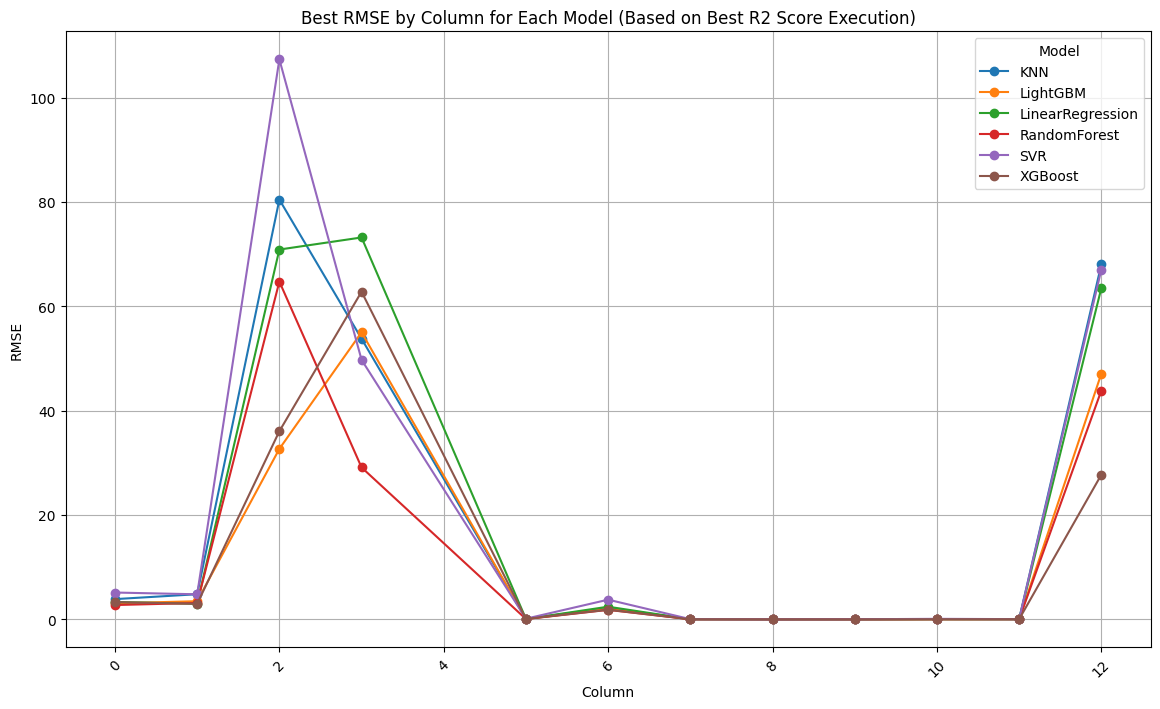

In [ ]:
# RMSE Line graph
def load_and_plot_best_model_rmse(file_path):

    df = pd.read_csv(file_path)

    # Calculate the mean R2 score for each model execution
    df['mean_r2_score'] = df.groupby(['model', 'repeat'])['r2_score'].transform('mean')
    best_executions = df.loc[df.groupby('model')['mean_r2_score'].idxmax()]

    plt.figure(figsize=(14, 8))

    # Plot RMSE values for the best execution of each model
    for model in best_executions['model'].unique():
        model_df = df[(df['model'] == model) & (df['repeat'] == best_executions[best_executions['model'] == model]['repeat'].values[0])]
        plt.plot(model_df['column'], model_df['rmse'], marker='o', label=model)

    plt.title('Best RMSE by Column for Each Model (Based on Best R2 Score Execution)')
    plt.xlabel('Column')
    plt.ylabel('RMSE')
    plt.legend(title='Model')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


file_path = '/content/results.csv'
load_and_plot_best_model_rmse(file_path)
